# Elastic Rod Model

In [1]:
from IPython.display import display, Markdown
import random
def latexify(x):
    out = '$' + x + '$'
    return out

def lprint(x):
    display(Markdown(latexify(latex(x))))
    
%run -i 'implicit.py'

import matplotlib.pyplot as plt

In this notebook a discretisation of the elastic rod bifurcation problem will be investigated

here we consider rods connected by elastic joints that resist angular perturbation, with a forcing action attempting to squash the rod

In [2]:
var('x')

lprint(arcsin(x))

$ \arcsin\left(x\right) $

In [59]:
def get_funcs(n):
    # returns a set of equations to solve

    var_dict = {}
    for i in range(0,n):
        # theta is the angle from the horizontal the ith line branches from
        var_dict['theta{}'.format(i)] = var('theta{}'.format(i), latex_name = r'\theta_{}'.format(i))
        
    var_dict['theta{}'.format(n)] = 0 # will update
        
    # compute the last theta, since must have the endpoints both zero on the vertical
    for i in range(0,n):
        var_dict['theta{}'.format(n)] = var_dict['theta{}'.format(n)] - sin(var_dict['theta{}'.format(i)])
        
    var_dict['theta{}'.format(n)] = arcsin(var_dict['theta{}'.format(n)])
    
    var_dict['l'] = var('l', latex_name=r'\lambda') # compressive force
   
    
    funcs = []
    energy = 0
    for j in range(1,n+1):
        # iterate through each spring in the rod
        e_spring = (var_dict['theta{}'.format(j-1)] - var_dict['theta{}'.format(j)])^2 
        # since pi - (pi - theta0 - theta1) e.g
        energy = energy + e_spring
        
    hoz = 0
    for i in range(0,n+1):
        # total horizontal extension
        hoz = hoz + cos(var_dict['theta{}'.format(i)])
           
    # take away the work done by the force
    energy = energy - var_dict['l']*(n + 1 - hoz)
            
    # solutions will be local minima of the energy equation
    for j in range(0,n):
        #don't care about the last angle
        funcs.append(energy.diff(var_dict['theta{}'.format(j)]))
        
    del var_dict['theta{}'.format(n)] # this was just a latent variable
        
    return funcs, var_dict

def angles_to_coords(angles):
    # produces the coordinates of a line with angles inputted
    coords = []
    coords.append((0,0))
    
    sin_sum = sum([sin(angle) for angle in angles])
    temp_angles = list(angles)
    temp_angles.append(arcsin(-sin_sum))
    
    for angle in temp_angles:
        now = coords[-1]
        new_x = now[0] + cos(angle)
        new_y = now[1] + sin(angle)
        coords.append((new_x, new_y))
        
        
    return coords

def plot_angles(angles, save = False, save_name = 'plot1', folder = 'plots', show = True, title=None):

    plt.axes
    plt.xlim([-1,4])
    plt.ylim([-2.5,2.5])

    points = angles_to_coords(tuple(angles))
    for i in range(int(0), int(len(points) - 1)):
        line = plt.Line2D((points[i][0], points[i+1][0]), (points[i][1], points[i+1][1]), lw=2.5)
        plt.gca().add_line(line)
        plt.gca().set_aspect('equal')
        if title is not None:
            plt.title(title)
    if save is True:
        plt.savefig('{}/{}.png'.format(folder, save_name))
        
    if show is True:
        plt.show()
        
    plt.cla()
    return   

In [4]:
funcs, var_dict = get_funcs(2)

In [5]:
var_dict

{'theta0': theta0, 'theta1': theta1, 'l': l}

In [6]:
lprint(funcs)

$ \left[-{\left(\frac{{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)} \cos\left({\theta_0}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + \sin\left({\theta_0}\right)\right)} {\lambda} + \frac{2 \, {\left({\theta_1} - \arcsin\left(-\sin\left({\theta_0}\right) - \sin\left({\theta_1}\right)\right)\right)} \cos\left({\theta_0}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + 2 \, {\theta_0} - 2 \, {\theta_1}, -{\left(\frac{{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)} \cos\left({\theta_1}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + \sin\left({\theta_1}\right)\right)} {\lambda} + 2 \, {\left({\theta_1} - \arcsin\left(-\sin\left({\theta_0}\right) - \sin\left({\theta_1}\right)\right)\right)} {\left(\frac{\cos\left({\theta_1}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + 1\right)} - 2 \, {\theta_0} + 2 \, {\theta_1}\right] $

In [7]:
lprint(funcs[1](l,0,0))

$ 0 $

See that we have trivial solutions

In [8]:
old_var = var_dict
var_dict = {key : var_dict[key] for key in var_dict.keys() if var_dict[key] != 0}
var_dict = {key : var_dict[key] for key in var_dict.keys() if key != 'l'}

J = jacobian(funcs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())
lprint(J)

$ \left(\begin{array}{rr}
-2 \, {\lambda} + 4 & -{\lambda} + 2 \\
-{\lambda} + 2 & -2 \, {\lambda} + 10
\end{array}\right) $

In [9]:
lprint(det(matrix(J))) # potential bifurcation point

$ -{\left({\lambda} - 2\right)}^{2} + 4 \, {\left({\lambda} - 2\right)} {\left({\lambda} - 5\right)} $

In [10]:
lprint(solve(det(matrix(J)), l))

$ \left[{\lambda} = 2, {\lambda} = 6\right] $

We see there are two different force strenghts that seem to produce bifurcations

In [11]:
bifs = list(solve(det(matrix(J)), l))
bif_tuples = []

for i in [0,1]:
    bif_funcs = [func(l = bifs[i].rhs()) for func in funcs]
    J = jacobian(bif_funcs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x : float(x))
    # do floating point since we are only looking right now
    K = [epair for epair in J.eigenvectors_right() if abs(epair[0]) < 10e-15][0][1][0] # since float now a solution is found as a highly degenerate eigenvector
    bif_tuples.append((bifs[i].rhs(), K))

In [12]:
bif_tuples

[(2, (1.0, 0.0)), (6, (0.4472135954999579, -0.8944271909999159))]

In [13]:
angles = tuple(bif_tuples[0][1])

2


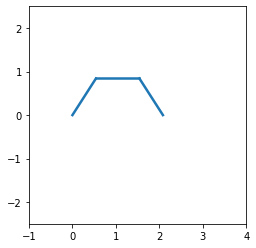

6


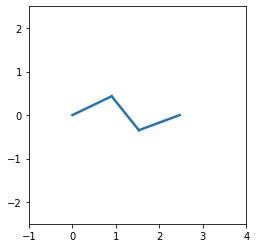

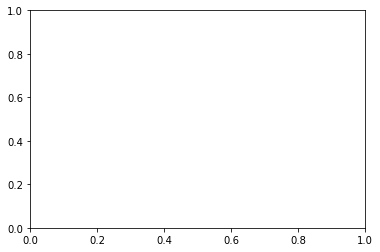

In [14]:
count = 1
for bif_tuple in bif_tuples:
    print(bif_tuple[0])
    plot_angles(bif_tuple[1], save = True, save_name = 'plot{}'.format(count))
    count+=1

# $\lambda = 2 $

\\_/ bifurcation

In [15]:
bif_funcs = [func(l = 2) for func in funcs]
J = jacobian(bif_funcs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()})
lprint(J)

$ \left(\begin{array}{rr}
0 & 0 \\
0 & 6
\end{array}\right) $

We see there is no need to reorder the variables

In [16]:
tfuncs = vector([func(l = l + 2) for func in funcs]) 
var_dict['l'] = l
var_dict_old = var_dict

In [17]:
position = {key : 0 for key in var_dict_old.keys()}


code_funcs = [tfuncs[index] for index in [1]] # the last function has degenerate first derivative always
position = {key : 0 for key in var_dict_old.keys()}
# var_dict already loaded
var_dict = {'y1' : theta1, 'x1' : l, 'x2' : theta0}
x_var_keys = ['l', 'theta0'] # the variables in the kernel
x_dim = 2
y_dim = 1 # invertible part

t_dict = TensorDict(code_funcs, position, var_dict, x_dim, y_dim)

computing Taylor approximaton to 3 order for speedup


In [18]:
out = get_hkx_polynomial(code_funcs, 5, x_dim, y_dim, var_dict, x_var_keys, t_dict, position)

100%|██████████| 1/1 [00:00<00:00, 23.25it/s]


[6]


100%|██████████| 4/4 [00:00<00:00, 16.32it/s]


[6]


100%|██████████| 14/14 [00:01<00:00, 12.16it/s]


[6]


  0%|          | 0/51 [00:00<?, ?it/s]

updating Taylor series


100%|██████████| 51/51 [00:06<00:00,  8.03it/s]


[6]


  0%|          | 0/202 [00:00<?, ?it/s]

updating Taylor series


100%|██████████| 202/202 [00:41<00:00,  4.82it/s]


[6]


In [19]:
lprint(out)

$ \left[\frac{4}{81} \, {\lambda}^{4} {\theta_0} - \frac{17}{81} \, {\lambda}^{2} {\theta_0}^{3} + \frac{7}{120} \, {\theta_0}^{5} + \frac{2}{27} \, {\lambda}^{3} {\theta_0} - \frac{25}{108} \, {\lambda} {\theta_0}^{3} + \frac{1}{9} \, {\lambda}^{2} {\theta_0} - \frac{1}{18} \, {\theta_0}^{3} + \frac{1}{6} \, {\lambda} {\theta_0}\right] $

In [20]:
subbed = [func(theta1 = out[0]) for func in tfuncs]
[float(func(l = 0.1, theta0 = 0.1)) for func in subbed]

[-0.01945458239316018, 0.0002431365259273066]

The first function remains to be solved

In [32]:
tf_taylor = tfuncs[0].taylor(*[(key,value) for key,value in position.items()],5) # taylor expand the function with degenerate image
lprint(tf_taylor.polynomial(SR)) # all three variables are present

$ \left(-\frac{1}{30}\right) \theta_{0}^{5} + \frac{3}{4} \theta_{0}^{4} \theta_{1} + \frac{25}{6} \theta_{0}^{3} \theta_{1}^{2} + \frac{41}{6} \theta_{0}^{2} \theta_{1}^{3} + \frac{47}{12} \theta_{0} \theta_{1}^{4} + \frac{17}{30} \theta_{1}^{5} + \frac{1}{3} l \theta_{0}^{3} - l \theta_{0}^{2} \theta_{1} + \left(-\frac{3}{2}\right) l \theta_{0} \theta_{1}^{2} + \left(-\frac{1}{3}\right) l \theta_{1}^{3} + \frac{2}{3} \theta_{0}^{3} + \theta_{0}^{2} \theta_{1} + 3 \theta_{0} \theta_{1}^{2} + \frac{4}{3} \theta_{1}^{3} + \left(-2\right) l \theta_{0} - l \theta_{1} $

In [33]:
tf_sub = tf_taylor(theta1 = out[0])

In [34]:
local = symbolic_expression(sum([a[0]*a[1] for a in tf_sub.polynomial(SR) if a[1].degree() <= 5]))
lprint(local) # will see that we can take out a factor of theta0 = xi0

$ -\frac{2}{27} \, {\lambda}^{4} {\theta_0} + \frac{7}{27} \, {\lambda}^{2} {\theta_0}^{3} - \frac{4}{45} \, {\theta_0}^{5} - \frac{1}{9} \, {\lambda}^{3} {\theta_0} + \frac{5}{9} \, {\lambda} {\theta_0}^{3} - \frac{1}{6} \, {\lambda}^{2} {\theta_0} + \frac{2}{3} \, {\theta_0}^{3} - 2 \, {\lambda} {\theta_0} $

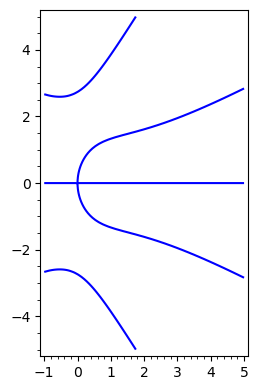

In [35]:
implicit_plot(local, (-1,5), (-5,5))

In [38]:
lprint(solve(local, theta0))

$ \left[{\theta_0} = -\frac{1}{2} \, \sqrt{\frac{35}{6} \, {\lambda}^{2} + \frac{25}{2} \, {\lambda} + \frac{1}{6} \, \sqrt{745 \, {\lambda}^{4} + 4530 \, {\lambda}^{3} + 10845 \, {\lambda}^{2} + 540 \, {\lambda} + 8100} + 15}, {\theta_0} = \frac{1}{2} \, \sqrt{\frac{35}{6} \, {\lambda}^{2} + \frac{25}{2} \, {\lambda} + \frac{1}{6} \, \sqrt{745 \, {\lambda}^{4} + 4530 \, {\lambda}^{3} + 10845 \, {\lambda}^{2} + 540 \, {\lambda} + 8100} + 15}, {\theta_0} = -\frac{1}{2} \, \sqrt{\frac{35}{6} \, {\lambda}^{2} + \frac{25}{2} \, {\lambda} - \frac{1}{6} \, \sqrt{745 \, {\lambda}^{4} + 4530 \, {\lambda}^{3} + 10845 \, {\lambda}^{2} + 540 \, {\lambda} + 8100} + 15}, {\theta_0} = \frac{1}{2} \, \sqrt{\frac{35}{6} \, {\lambda}^{2} + \frac{25}{2} \, {\lambda} - \frac{1}{6} \, \sqrt{745 \, {\lambda}^{4} + 4530 \, {\lambda}^{3} + 10845 \, {\lambda}^{2} + 540 \, {\lambda} + 8100} + 15}, {\theta_0} = 0\right] $

In [55]:
sols = [solve(local, theta0)[2].rhs(), out[0](theta0 = solve(local, theta0)[2].rhs())]

In [56]:
coords = { list(var_dict_old.keys())[i] : sols[i] for i in [0,1] }
sym_funcs = [func.function(*list(var_dict_old.values()))(l = l + 2) for func in funcs]

In [57]:
lprint(sym_funcs)

$ \left[-{\left(\frac{{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)} \cos\left({\theta_0}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + \sin\left({\theta_0}\right)\right)} {\left({\lambda} + 2\right)} + \frac{2 \, {\left({\theta_1} - \arcsin\left(-\sin\left({\theta_0}\right) - \sin\left({\theta_1}\right)\right)\right)} \cos\left({\theta_0}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + 2 \, {\theta_0} - 2 \, {\theta_1}, -{\left(\frac{{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)} \cos\left({\theta_1}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + \sin\left({\theta_1}\right)\right)} {\left({\lambda} + 2\right)} + 2 \, {\left({\theta_1} - \arcsin\left(-\sin\left({\theta_0}\right) - \sin\left({\theta_1}\right)\right)\right)} {\left(\frac{\cos\left({\theta_1}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + 1\right)} - 2 \, {\theta_0} + 2 \, {\theta_1}\right] $

In [58]:
vector([float(func(**coords)(l = 0.01)) for func in sym_funcs])

(1.5916886929033636e-07, 7.352548411943123e-07)

100%|██████████| 150/150 [00:27<00:00,  5.39it/s]


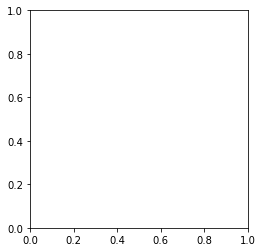

In [66]:
for i in tqdm.tqdm(range(0,150)):
    
    angles = [-sol(l = i/1000) for sol in sols] # the upwards bending looks better, a solution by symmetry
    plot_angles(angles, save = True, save_name = 'lambda2/plot{}'.format(str(i)), show = False, title = 'lambda = 2.{}'.format(f'{i:03d}'))

Suggest bifurcations at $\lambda = 6$ and $\lambda = 2$

# $\lambda = 6$

In [125]:
funcs, var_dict = get_funcs(2)

var_dict = {key : var_dict[key] for key in var_dict.keys() if var_dict[key] != 0}
var_dict = {key : var_dict[key] for key in var_dict.keys() if key != 'l'}
bif_funcs = [func(l =6) for func in funcs]
#var_dict['l'] = old_var['l']
J = jacobian(bif_funcs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()})

lprint(J)

$ \left(\begin{array}{rr}
-8 & -4 \\
-4 & -2
\end{array}\right) $

### Orthogonalising the kernel

In [126]:
K = J.right_kernel().basis()
lprint(K)

$ \left[\left(1,\,-2\right)\right] $

In [127]:
Kperp = matrix(K).right_kernel().basis()
lprint(Kperp)

$ \left[\left(1,\,\frac{1}{2}\right)\right] $

In [128]:
A = matrix(K+Kperp).transpose()
lprint(A)

$ \left(\begin{array}{rr}
1 & 1 \\
-2 & \frac{1}{2}
\end{array}\right) $

In [129]:
key_list = [str(var) for var in var_dict.values()]
value_list = list(A*vector(var_dict.values()))
mutate_dict = dict(zip(key_list, value_list))

In [130]:
mutate_dict

{'theta0': theta0 + theta1, 'theta1': -2*theta0 + 1/2*theta1}

In [131]:
Afuncs = [func(**mutate_dict) for func in bif_funcs]

In [132]:
#lprint(Afuncs) 

In [133]:
Ja = jacobian(Afuncs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())
lprint(Ja)

$ \left(\begin{array}{rr}
0 & -10 \\
0 & -5
\end{array}\right) $

In [134]:
Ka = Ja(l=0).right_kernel().basis()
lprint(Ka)

$ \left[\left(1,\,0\right)\right] $

### Orthogonalising the image

In [135]:
I = Ja.image().basis()
I = [Ja*vec for vec in I]
print(len(I))

1


In [136]:
Iperp = matrix(I).right_kernel().basis()
lprint(Iperp)

$ \left[\left(1,\,-2\right)\right] $

In [137]:
B = matrix(I + Iperp).transpose().inverse().apply_map(lambda x: x.full_simplify())
lprint(B)

$ \left(\begin{array}{rr}
-\frac{2}{25} & -\frac{1}{25} \\
\frac{1}{5} & -\frac{2}{5}
\end{array}\right) $

In [138]:
tfuncs = B*vector(Afuncs)

In [139]:
#lprint(tfuncs)

In [140]:
Jt = jacobian(tfuncs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())

In [141]:
lprint(Jt)

$ \left(\begin{array}{rr}
0 & 1 \\
0 & 0
\end{array}\right) $

In [142]:
var_dict.values()

dict_values([theta0, theta1])

In [143]:
It = Jt.image().basis()
It = [Jt*vec for vec in It]
lprint(It)

$ \left[\left(1,\,0\right)\right] $

## Adding lambda back in

In [144]:
tfuncs = B*vector([func(**mutate_dict)(l = l + 6) for func in funcs])# now lambda is not fixed at the bifurcation point
# ***IF SOMETHING IS BROKEN CHECK RIGHT LAMBDA HERE***
# but we do shift so that l=0 is the new bifurcation
var_dict['l'] = l

In [145]:
var_dict_old = var_dict
var_dict_old

{'theta0': theta0, 'theta1': theta1, 'l': l}

In [146]:
var_dict.values()

dict_values([theta0, theta1, l])

In [147]:
lprint(tfuncs[1])

$ -\frac{1}{5} \, {\left(\frac{{\left(\sin\left({\theta_0} + {\theta_1}\right) + \sin\left(-2 \, {\theta_0} + \frac{1}{2} \, {\theta_1}\right)\right)} \cos\left({\theta_0} + {\theta_1}\right)}{\sqrt{-{\left(\sin\left({\theta_0} + {\theta_1}\right) + \sin\left(-2 \, {\theta_0} + \frac{1}{2} \, {\theta_1}\right)\right)}^{2} + 1}} + \sin\left({\theta_0} + {\theta_1}\right)\right)} {\left({\lambda} + 6\right)} + \frac{2}{5} \, {\left(\frac{{\left(\sin\left({\theta_0} + {\theta_1}\right) + \sin\left(-2 \, {\theta_0} + \frac{1}{2} \, {\theta_1}\right)\right)} \cos\left(-2 \, {\theta_0} + \frac{1}{2} \, {\theta_1}\right)}{\sqrt{-{\left(\sin\left({\theta_0} + {\theta_1}\right) + \sin\left(-2 \, {\theta_0} + \frac{1}{2} \, {\theta_1}\right)\right)}^{2} + 1}} + \sin\left(-2 \, {\theta_0} + \frac{1}{2} \, {\theta_1}\right)\right)} {\left({\lambda} + 6\right)} + \frac{2}{5} \, {\left(4 \, {\theta_0} - {\theta_1} + 2 \, \arcsin\left(-\sin\left({\theta_0} + {\theta_1}\right) - \sin\left(-2 \, {\theta_0} + \frac{1}{2} \, {\theta_1}\right)\right)\right)} {\left(\frac{\cos\left(-2 \, {\theta_0} + \frac{1}{2} \, {\theta_1}\right)}{\sqrt{-{\left(\sin\left({\theta_0} + {\theta_1}\right) + \sin\left(-2 \, {\theta_0} + \frac{1}{2} \, {\theta_1}\right)\right)}^{2} + 1}} + 1\right)} - \frac{{\left(4 \, {\theta_0} - {\theta_1} + 2 \, \arcsin\left(-\sin\left({\theta_0} + {\theta_1}\right) - \sin\left(-2 \, {\theta_0} + \frac{1}{2} \, {\theta_1}\right)\right)\right)} \cos\left({\theta_0} + {\theta_1}\right)}{5 \, \sqrt{-{\left(\sin\left({\theta_0} + {\theta_1}\right) + \sin\left(-2 \, {\theta_0} + \frac{1}{2} \, {\theta_1}\right)\right)}^{2} + 1}} + \frac{18}{5} \, {\theta_0} + \frac{3}{5} \, {\theta_1} $

## Running the implicit function theorem

In [148]:
len(tfuncs)

2

In [149]:
position = {key : 0 for key in var_dict_old.keys()}
position

{'theta0': 0, 'theta1': 0, 'l': 0}

In [150]:
var_dict['l'] = l
var_dict_old = var_dict

In [151]:
#code_funcs = [tfuncs[index].function(*list(var_dict_old.values())) for index in [0,1,2,3,4,5,6]] # careful with computer science indexing from zero
code_funcs = [tfuncs[index] for index in [0]] # the last function has degenerate first derivative always
position = {key : 0 for key in var_dict_old.keys()}
# var_dict already loaded
var_dict = {'y1' : theta1, 'x1' : l, 'x2' : theta0}
x_var_keys = ['l', 'theta0'] # the variables in the kernel
x_dim = 2
y_dim = 1 # invertible part

In [152]:
var_dict.keys()

dict_keys(['y1', 'x1', 'x2'])

In [153]:
t_dict = TensorDict(code_funcs, position, var_dict, x_dim, y_dim)

computing Taylor approximaton to 3 order for speedup


In [154]:
out = get_hkx_polynomial(code_funcs, 5, x_dim, y_dim, var_dict, x_var_keys, t_dict, position)

100%|██████████| 1/1 [00:00<00:00, 24.79it/s]


[1]


100%|██████████| 4/4 [00:00<00:00, 13.42it/s]


[1]


100%|██████████| 14/14 [00:01<00:00, 12.18it/s]


[1]


  0%|          | 0/51 [00:00<?, ?it/s]

updating Taylor series


100%|██████████| 51/51 [00:06<00:00,  7.72it/s]


[1]


  0%|          | 0/202 [00:00<?, ?it/s]

updating Taylor series


100%|██████████| 202/202 [00:42<00:00,  4.74it/s]


[1]


In [155]:
lprint(out) # our h function

$ \left[-\frac{8232}{390625} \, {\lambda}^{4} {\theta_0} - \frac{20333}{31250} \, {\lambda}^{2} {\theta_0}^{3} - \frac{7669}{2500} \, {\theta_0}^{5} + \frac{588}{15625} \, {\lambda}^{3} {\theta_0} + \frac{961}{1250} \, {\lambda} {\theta_0}^{3} - \frac{42}{625} \, {\lambda}^{2} {\theta_0} - \frac{19}{25} \, {\theta_0}^{3} + \frac{3}{25} \, {\lambda} {\theta_0}\right] $

## Testing the implicit function theorem

In [156]:
subbed = [func(theta1 = out[0]) for func in tfuncs]

In [157]:
[float(func(l = 0.1, theta0 = 0.1)) for func in subbed]

[-1.4134419517586316e-06, -0.008314743254685286]

the last function remains to be solved

### Looking for more solutions

Now substitute this into the equation that had degenerate image

In [158]:
tf_taylor = tfuncs[1].taylor(*[(key,value) for key,value in position.items()],5) # taylor expand the function with degenerate image
lprint(tf_taylor.polynomial(SR)) # all three variables are present

$ \left(-\frac{213}{50}\right) \theta_{0}^{5} + \frac{313}{40} \theta_{0}^{4} \theta_{1} + \frac{81}{40} \theta_{0}^{3} \theta_{1}^{2} + \left(-\frac{553}{80}\right) \theta_{0}^{2} \theta_{1}^{3} + \left(-\frac{161}{320}\right) \theta_{0} \theta_{1}^{4} + \frac{68}{75} \theta_{1}^{5} + \frac{7}{5} l \theta_{0}^{3} + \left(-\frac{9}{5}\right) l \theta_{0}^{2} \theta_{1} + \frac{13}{40} l \theta_{0} \theta_{1}^{2} + \frac{2}{5} l \theta_{1}^{3} + \frac{18}{5} \theta_{0}^{3} + \left(-\frac{57}{10}\right) \theta_{0}^{2} \theta_{1} + \frac{81}{20} \theta_{0} \theta_{1}^{2} + \frac{17}{20} \theta_{1}^{3} + \left(-\frac{6}{5}\right) l \theta_{0} + \frac{3}{10} l \theta_{1} $

In [159]:
tf_sub = tf_taylor(theta1 = out[0]) # substitute in h

In [160]:
local = symbolic_expression(sum([a[0]*a[1] for a in tf_sub.polynomial(SR) if a[1].degree() <= 5]))
#local = tf_sub.polynomial(SR).truncate(4)
lprint(local) # will see that we can take out a factor of theta0 = xi0

$ \frac{882}{78125} \, {\lambda}^{4} {\theta_0} + \frac{57}{125} \, {\lambda}^{2} {\theta_0}^{3} + \frac{9}{125} \, {\theta_0}^{5} - \frac{63}{3125} \, {\lambda}^{3} {\theta_0} + \frac{61}{125} \, {\lambda} {\theta_0}^{3} + \frac{9}{250} \, {\lambda}^{2} {\theta_0} + \frac{18}{5} \, {\theta_0}^{3} - \frac{6}{5} \, {\lambda} {\theta_0} $

We see that this will have solutions, therefore the point $\lambda$ is indeed a bifurcation point, and if we fix the $p10x$ variable at zero then $\lambda$ will span the local solutions.

In [161]:
lprint(solve(local, theta0))

$ \left[{\theta_0} = -\frac{1}{15} \, \sqrt{-\frac{1425}{2} \, {\lambda}^{2} - \frac{1525}{2} \, {\lambda} + \frac{1}{2} \, \sqrt{1998873 \, {\lambda}^{4} + 4402950 \, {\lambda}^{3} + 34286875 \, {\lambda}^{2} + 37687500 \, {\lambda} + 126562500} - 5625}, {\theta_0} = \frac{1}{15} \, \sqrt{-\frac{1425}{2} \, {\lambda}^{2} - \frac{1525}{2} \, {\lambda} + \frac{1}{2} \, \sqrt{1998873 \, {\lambda}^{4} + 4402950 \, {\lambda}^{3} + 34286875 \, {\lambda}^{2} + 37687500 \, {\lambda} + 126562500} - 5625}, {\theta_0} = -\frac{1}{15} \, \sqrt{-\frac{1425}{2} \, {\lambda}^{2} - \frac{1525}{2} \, {\lambda} - \frac{1}{2} \, \sqrt{1998873 \, {\lambda}^{4} + 4402950 \, {\lambda}^{3} + 34286875 \, {\lambda}^{2} + 37687500 \, {\lambda} + 126562500} - 5625}, {\theta_0} = \frac{1}{15} \, \sqrt{-\frac{1425}{2} \, {\lambda}^{2} - \frac{1525}{2} \, {\lambda} - \frac{1}{2} \, \sqrt{1998873 \, {\lambda}^{4} + 4402950 \, {\lambda}^{3} + 34286875 \, {\lambda}^{2} + 37687500 \, {\lambda} + 126562500} - 5625}, {\theta_0} = 0\right] $

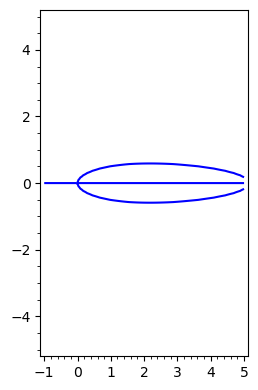

In [162]:
implicit_plot(local, (-1,5), (-5,5))

looks like a bifurcation to me

In [163]:
sols = [solve(local, theta0)[0].rhs(), out[0](theta0 = solve(local, theta0)[0].rhs())] # now solutions are spanned by lambda
        # theta0 = g(l)                 # theta1 = h(g(l), l)

lprint(sols) # now only in terms of lambda

$ \left[-\frac{1}{15} \, \sqrt{-\frac{1425}{2} \, {\lambda}^{2} - \frac{1525}{2} \, {\lambda} + \frac{1}{2} \, \sqrt{1998873 \, {\lambda}^{4} + 4402950 \, {\lambda}^{3} + 34286875 \, {\lambda}^{2} + 37687500 \, {\lambda} + 126562500} - 5625}, \frac{2744}{1953125} \, \sqrt{-\frac{1425}{2} \, {\lambda}^{2} - \frac{1525}{2} \, {\lambda} + \frac{1}{2} \, \sqrt{1998873 \, {\lambda}^{4} + 4402950 \, {\lambda}^{3} + 34286875 \, {\lambda}^{2} + 37687500 \, {\lambda} + 126562500} - 5625} {\lambda}^{4} + \frac{20333}{105468750} \, {\left(-\frac{1425}{2} \, {\lambda}^{2} - \frac{1525}{2} \, {\lambda} + \frac{1}{2} \, \sqrt{1998873 \, {\lambda}^{4} + 4402950 \, {\lambda}^{3} + 34286875 \, {\lambda}^{2} + 37687500 \, {\lambda} + 126562500} - 5625\right)}^{\frac{3}{2}} {\lambda}^{2} - \frac{196}{78125} \, \sqrt{-\frac{1425}{2} \, {\lambda}^{2} - \frac{1525}{2} \, {\lambda} + \frac{1}{2} \, \sqrt{1998873 \, {\lambda}^{4} + 4402950 \, {\lambda}^{3} + 34286875 \, {\lambda}^{2} + 37687500 \, {\lambda} + 126562500} - 5625} {\lambda}^{3} + \frac{7669}{1898437500} \, {\left(-\frac{1425}{2} \, {\lambda}^{2} - \frac{1525}{2} \, {\lambda} + \frac{1}{2} \, \sqrt{1998873 \, {\lambda}^{4} + 4402950 \, {\lambda}^{3} + 34286875 \, {\lambda}^{2} + 37687500 \, {\lambda} + 126562500} - 5625\right)}^{\frac{5}{2}} - \frac{961}{4218750} \, {\left(-\frac{1425}{2} \, {\lambda}^{2} - \frac{1525}{2} \, {\lambda} + \frac{1}{2} \, \sqrt{1998873 \, {\lambda}^{4} + 4402950 \, {\lambda}^{3} + 34286875 \, {\lambda}^{2} + 37687500 \, {\lambda} + 126562500} - 5625\right)}^{\frac{3}{2}} {\lambda} + \frac{14}{3125} \, \sqrt{-\frac{1425}{2} \, {\lambda}^{2} - \frac{1525}{2} \, {\lambda} + \frac{1}{2} \, \sqrt{1998873 \, {\lambda}^{4} + 4402950 \, {\lambda}^{3} + 34286875 \, {\lambda}^{2} + 37687500 \, {\lambda} + 126562500} - 5625} {\lambda}^{2} + \frac{19}{84375} \, {\left(-\frac{1425}{2} \, {\lambda}^{2} - \frac{1525}{2} \, {\lambda} + \frac{1}{2} \, \sqrt{1998873 \, {\lambda}^{4} + 4402950 \, {\lambda}^{3} + 34286875 \, {\lambda}^{2} + 37687500 \, {\lambda} + 126562500} - 5625\right)}^{\frac{3}{2}} - \frac{1}{125} \, \sqrt{-\frac{1425}{2} \, {\lambda}^{2} - \frac{1525}{2} \, {\lambda} + \frac{1}{2} \, \sqrt{1998873 \, {\lambda}^{4} + 4402950 \, {\lambda}^{3} + 34286875 \, {\lambda}^{2} + 37687500 \, {\lambda} + 126562500} - 5625} {\lambda}\right] $

In [164]:
coords = { list(var_dict_old.keys())[i] : sols[i] for i in [0,1] }
coords
[tfuncs[i](**coords)(l = 0.01) for i in [0,1]] # see that we solve both equations

[6.20229049029530e-7, -3.05906829034530e-9]

However solutions are in the reformed space, needed to undo the action that reorganised the kernel

### Generating more solutions

We have solved $f \circ A$ where $A$ orthogonalised the kernel, thus by applying $A$ we can get a traversel of the new solutions.

In [165]:
lprint(A)

$ \left(\begin{array}{rr}
1 & 1 \\
-2 & \frac{1}{2}
\end{array}\right) $

In [166]:
fsols = list(A*vector(sols))
len(fsols)

2

In [167]:
#fsols = [random.random()/10000 for i in range(0,2)] # can check these are giving solutions

In [168]:
coords = { list(var_dict_old.keys())[i] : fsols[i] for i in [0,1] }
coords

{'theta0': 2744/1953125*sqrt(-1425/2*l^2 - 1525/2*l + 1/2*sqrt(1998873*l^4 + 4402950*l^3 + 34286875*l^2 + 37687500*l + 126562500) - 5625)*l^4 + 20333/105468750*(-1425/2*l^2 - 1525/2*l + 1/2*sqrt(1998873*l^4 + 4402950*l^3 + 34286875*l^2 + 37687500*l + 126562500) - 5625)^(3/2)*l^2 - 196/78125*sqrt(-1425/2*l^2 - 1525/2*l + 1/2*sqrt(1998873*l^4 + 4402950*l^3 + 34286875*l^2 + 37687500*l + 126562500) - 5625)*l^3 + 7669/1898437500*(-1425/2*l^2 - 1525/2*l + 1/2*sqrt(1998873*l^4 + 4402950*l^3 + 34286875*l^2 + 37687500*l + 126562500) - 5625)^(5/2) - 961/4218750*(-1425/2*l^2 - 1525/2*l + 1/2*sqrt(1998873*l^4 + 4402950*l^3 + 34286875*l^2 + 37687500*l + 126562500) - 5625)^(3/2)*l + 14/3125*sqrt(-1425/2*l^2 - 1525/2*l + 1/2*sqrt(1998873*l^4 + 4402950*l^3 + 34286875*l^2 + 37687500*l + 126562500) - 5625)*l^2 + 19/84375*(-1425/2*l^2 - 1525/2*l + 1/2*sqrt(1998873*l^4 + 4402950*l^3 + 34286875*l^2 + 37687500*l + 126562500) - 5625)^(3/2) - 1/125*sqrt(-1425/2*l^2 - 1525/2*l + 1/2*sqrt(1998873*l^4 + 4402950*

In [169]:
sym_funcs = [func.function(*list(var_dict_old.values()))(l = l + 6) for func in funcs] # convert to symbolic functions
# *** IF SOMETHING IS BREAKING CHECK THAT RIGHT SHIFT HERE ***

In [170]:
vector([float(func(**coords)(l = 0.01)) for func in sym_funcs])

(-6.205349558530138e-06, -3.095027107935522e-06)

We see that these solutions do indeed comprise a new set of solutions

In [61]:
for i in range(0,10):
    print(float(i/100), float(fsols[0](l = i/100)), float(fsols[1](l = i/100)))

0.0 0.0 0.0
0.01 -0.05760750448187771 0.11540886424115876
0.02 -0.08128661416098402 0.16312556369654008
0.03 -0.0993286827488509 0.19967957332207306
0.04 -0.11442972405422873 0.23044494175044178
0.05 -0.1276360086339418 0.2575043711153909
0.06 -0.1394849996589075 0.2819265364072334
0.07 -0.15029642126340803 0.30434659388508134
0.08 -0.16027883816976735 0.32517858781785536
0.09 -0.1695772610882078 0.34471025838721187


100%|██████████| 150/150 [00:29<00:00,  5.03it/s]


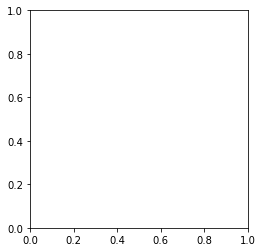

In [175]:
for i in tqdm.tqdm(range(0,150)):
    
    angles = [-fsol(l = i/1000) for fsol in fsols] # the upwards bending looks better, a solution by symmetry
    plot_angles(angles, save = True, save_name = 'lambda6/plot{}'.format(str(i)), show = False, title = 'lambda = 6.{}'.format(f'{i:03d}'))